<table align="left">
  <td>
    <a href="https://colab.research.google.com/drive/1PdKgCi-cE3uerh47dV06n_t7xo5TqLDJ" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
  </td>
</table>

# **Capítulo 5. Histogramas**

## Trabajando con **histogramas**

El histograma se puede visualizar como un gráfico de barras, donde en el eje horizontal se representan los niveles de intensidad y en el eje vertical se muestra la frecuencia de aparición de cada nivel. Los niveles de intensidad generalmente se representan en una escala de 0 a 255 para imágenes en escala de grises o para cada componente de color (rojo, verde, azul) en imágenes en color RGB.

In [1]:
import os
import cv2
import cv2
import cv2
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display, clear_output
from google.colab.patches import cv2_imshow
from google.colab import files


**Algunas funciones de apoyo**

Vamos a crear dos funciones de apoyo, una para subir una imagen al servidor, y otra que a partir de una rura aun fichero, suponiendo que es una inagen,la carga usando la librería OpenCV.

La primera, *subir_imagen*, permite que el usuario selecciones un archivo, lo sube al servidor y devuelve la ruta al fichero subido.

La segunda, a partir de la ruta de un archivo, carga la imagen y la devuelve.

In [2]:
def subir_imagen():
    # Pedir al usuario que seleccione un archivo
    uploaded = files.upload()

    # Obtener el nombre del archivo y su contenido
    file_name = next(iter(uploaded))
    file_content = uploaded[file_name]

    # Definir el directorio donde se almacenará el archivo (en Google Colab)
    target_dir = '/content/imagenes'
    if not os.path.exists(target_dir):
        os.makedirs(target_dir)

    # Almacenar el archivo en el directorio especificado
    file_path = os.path.join(target_dir, file_name)
    with open(file_path, 'wb') as f:
        f.write(file_content)

    return file_path


In [3]:
def leer_imagen(path):
    # Leer la imagen utilizando OpenCV
    image = cv2.imread(path)
    if image is None:
       raise ValueError("No se pudo leer la imagen. Asegúrate de que la ruta sea correcta y la imagen exista.")
    return image

## Cargando una imagen y mostrandola junto con su histograma

❗**Atención**: La imagen que cargemos será la usada en el resto del *notebook*.

**TODO**: por defecto carga una imagen del repositorio.

In [17]:
# Llamar a la función para pedir el archivo y obtener el path almacenado
ruta = subir_imagen()

imagen_opencv = leer_imagen(ruta)

# Convertir la imagen a escala de grises
imagen_gris = cv2.cvtColor(imagen_opencv, cv2.COLOR_BGR2GRAY)

# Obtener dimensiones originales
alto_original, ancho_original = imagen_gris.shape[:2]

# Especificar el nuevo ancho
nuevo_ancho = 600

# Calcular el factor de escala
factor_escala = nuevo_ancho / ancho_original

# Calcular el nuevo alto manteniendo la relación de aspecto
nuevo_alto = int(alto_original * factor_escala)

# Redimensionar la imagen
imagen_gris = cv2.resize(imagen_gris, (nuevo_ancho, nuevo_alto), interpolation=cv2.INTER_AREA)


Saving buenaresolución.png to buenaresolución (1).png


Una vez cargada, la mostramos junto con su histograma.

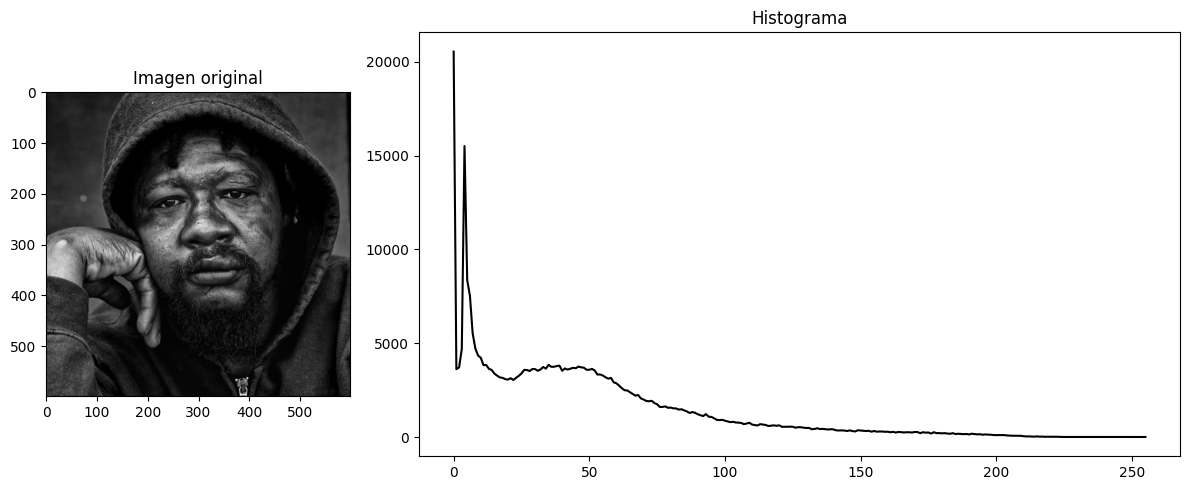

In [18]:
# Calcular el histograma
histograma = cv2.calcHist([imagen_gris], [0], None, [256], [0, 256])

# Mostrar el histograma
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5), gridspec_kw={'width_ratios': [2, 5]})
ax1.imshow(imagen_gris, cmap='gray')
ax1.set_title('Imagen original')

ax2.plot(histograma, color='black')
ax2.set_title('Histograma')

plt.tight_layout()
plt.show()

## Modificando la imagen por medio de la manipulación del histograma

Podemos usar el histograma para cambiar características de la imagen.

La más simple, eliminar determinados pixels, aquellos que están por debajo de un valor y aquellos que estén por encima de otro valor. A esta operación se la llama aplicar un **filtro paso banda**.

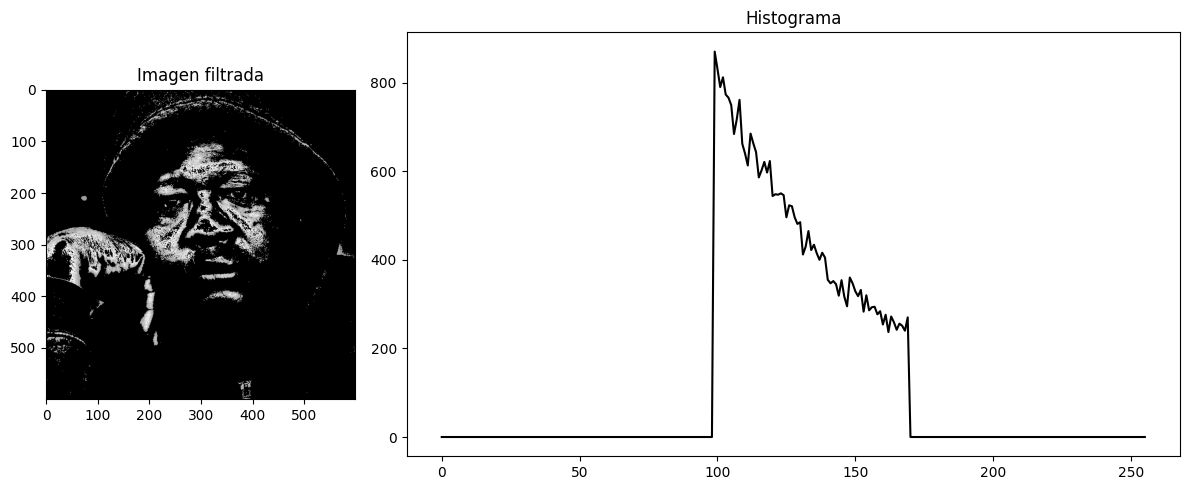

In [19]:
# Estos valores representan una banda (de 10 a 170) que se va a conservar; el resto se pondrá a 0.
filtro_inferior=100
filtro_superior=170
filtro_valor   =0

imagen_filtrada=imagen_gris.copy();
imagen_filtrada[imagen_gris<filtro_inferior]=filtro_valor;
imagen_filtrada[imagen_gris>filtro_superior]=filtro_valor;

# Calcular el histograma
histograma = cv2.calcHist([imagen_filtrada], [0], None, [256], [1, 256])

# Mostrar el histograma
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5), gridspec_kw={'width_ratios': [2, 5]})
ax1.imshow(imagen_filtrada, cmap='gray')
ax1.set_title('Imagen filtrada')

ax2.plot(histograma, color='black')
ax2.set_title('Histograma')

plt.tight_layout()
plt.show()

## Modificando el histograma interactivamente

Para ver más claramente lo que es un filtro paso banda, vamos a hacer un pequeño interface interactivo. Vamos a jugar en tiempo real con los valores del filtro.

### Instalando las librerías necesarias

In [13]:
# tenemos que instalar algunas cosas antes de usarlas
!pip install -q ipycanvas==0.11
!pip install -q ipyevents

### Activando los widgets en Google Colab

Esta celda sólo es necesaria en Google Colab.

In [14]:
# esto es necesario en Google Colab para que funcionen los widgets
from google.colab import output
output.enable_custom_widget_manager()

### Interactuando

Se trata de hacer un *filtro-paso-banda* en el histograma.

Para ello vamos a crear un *slider* que permita editar dos valores, el valor inferior (**fmin**) y superior del filtro (**fmax**).

Básicamente todo pixel con un valor inferior a **fmin** será puesto a cero (negro), y todo pixel con valor superior a **fmax** será puesto a 255 (blanco).

Si quieres cambiar el valor a poner, en vez de cero por el valor que quieras (entre 0 y 255, por defecto puso 0 en ambas) en las líneas 25 y 26.

In [21]:
from ipycanvas  import Canvas;

assert len(imagen_gris.shape)==2, "La imagen debe ser en tonos de grisis, y por tanto sólo un canal de color"

alto, ancho = imagen_gris.shape
canvas = Canvas(width=ancho, height=alto)
canvas.put_image_data(imagen_gris, 0, 0)
display(canvas);

slider=widgets.IntRangeSlider(value=[0, 255],
                              min=0,
                              max=255,
                              step=1,
                              description='Valores:',
                              disabled=False,
                              continuous_update=False,
                              orientation='horizontal',
                              readout=True,
                              readout_format='d',
                              layout={"width":f"{ancho}px"})

def slider_changed(value):
    fmn, fmx = value.new
    imagen_filtrada = imagen_gris.copy()
    imagen_filtrada[imagen_gris<fmn]=0;
    imagen_filtrada[imagen_gris>fmx]=0;
    canvas.put_image_data(imagen_filtrada, 0, 0)

slider.observe(slider_changed, names='value')
display(slider);

# NOTA: debes arrastrar los puntos del slider, no llega con hacer click en un valor!

Canvas(height=600, width=600)

IntRangeSlider(value=(0, 255), continuous_update=False, description='Valores:', layout=Layout(width='600px'), …